## License

This notebook is a conversion of a Sentinel Hub evalscript and is licensed under **CC-BY-SA-4.0.**  

Original evalscript: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/markuse_fire/  
Source: Sentinel Hub Custom Scripts (CC-BY-SA-4.0)  
Conversion: Development Seed (openEO-UDP project)

# Wildfire Visualization and OpenEO

This notebook demonstrates how to visualize wildfire occurrences using Sentinel-2 imagery. The visualization applies cartographic-style rendering that the author can switch between different purposes.

The available styles include:
1. A continuous heatmap-like visualization where fire intensity (from weak to strong) is encoded using SWIR-based thresholds and blended into a base map that preserves soil, built-up areas, vegetation, and water bodies.
2. Binary fire detection styles using read or yellow coloring to indicate the presence or absence of active fires.

The visualization also includes optional cloud avoidance logic to reduce false detections, and supports burn-scar highlighting using the Normalized Burn Ration (NBR) to visualize post-fire impacts.


In [18]:
import openeo
import matplotlib.pyplot as plt
from PIL import Image
from openeo.processes import array_create, if_, and_, array_element, sqrt, eq, constant

# Connect to OpenEO Backend
Connect to the OpenEO backend and authenticate using OpenID Connect.

In [19]:
connection = openeo.connect(
    url="https://api.explorer.eopf.copernicus.eu/openeo"
).authenticate_oidc_authorization_code()

# Define Area of Interest
Define the spatial extent for our analysis. This example uses coordinates for Central Portugal

In [20]:
# Central Portugal
spatial_extent = {
    "west": -8.05,
    "east": -7.47,
    "south": 40.03,
    "north": 40.45
}

# Load Sentinel-2 Data
Load Sentinel-2 L2A data. We need multiple bands to visualize the underlying land-cover information, water, and wildfire.

- **B02**: Blue, 492.4 nm
- **B03**: Green, 559.8 nm
- **B04**: Red, 664.6 nm
- **B08**: NIR, 832.8 nm
- **B8A**: Narrow NIR, 864.7 nm
- **B11**: SWIR, 1613.7 nm
- **B12**: SWIR, 2202.4 nm


In [21]:
s2cube = connection.load_collection(
    "sentinel-2-l2a",
    spatial_extent=spatial_extent,
    temporal_extent=["2025-08-19", "2025-08-22"],
    bands=["reflectance|b02", "reflectance|b03", "reflectance|b04", "reflectance|b08", "reflectance|b11", "reflectance|b12"]
)
s2cube = s2cube.reduce_dimension(dimension="time", reducer="first")  # single timestamp for PNG


### Wildfire Visualization Styles

The openEO workflow lets you choose among four preset visual styles for highlighting active fire pixels. You need to enable hotspot rendering to use any of these styles (`hotspot = 1`):

- **`style = 1` – Continuous heatmap**: Shows hotspots with a smooth color ramp, where **strong fire** appears in bright yellow and **weaker fire** in darker reds.
- **`style = 2` – Binary red mask**: Highlights pixels classified as fire in **bright red**, with non‑fire areas shown in a neutral background.
- **`style = 3` – Binary yellow mask**: Similar to style 2, but fire pixels are shown in **bright yellow**, useful on darker backgrounds or when combining with other layers.

You can also visualize burn scars by disabling hotspot rendering (`hotspot = 0`) and enabling burn scar rendering (`showBurnScars = 1`). Style selection only applies to hotspot visualization and is not available when `showBurnScars` is used.

In [22]:
# If user wants to visualize the hotspots, they can set the hotspot variable to 1
hotspot = 0

# If user wants to visualize the hotspots in a continuous heatmap-style, they can set the style variable to 1
style = 2

# If user wants to visualize the burn scars, they can set the showBurnScars variable to 1, and hotspot to 0
showBurnScars = 1

### Other Parameters
Below is default parameters to run the openEO workflow

In [23]:
# Define the file name for downloading the image
file_name = "wildfire_visualization.png"
if hotspot:
    if style:
        file_name = f"wildfire_hotspot_style{style}.png"
        if style == 1:
            plot_title = (
                "Wildfire Visualization of Different Intensity\n"
                "Yellow: Very High Fire (SWIR > 2.0) | Yellow-Orange: High Fire (1.5 < SWIR <= 2.0)\n"
                "Orange-Red: Medium Fire (1.25 < SWIR <= 1.5 | Red: Low Fire (1.0 < SWIR <= 1.25)\n"
                "Central Portugal, August 2025"
            )
        else:
            plot_title = (
                "Wildfire Visualization\n"
                "Central Portugal, August 2025"
            )
if showBurnScars:
    file_name = f"wildfire_burntscar.png"
    plot_title = (
        "Burnt Scar Visualization\n"
        "Central Portugal, August 2025"
    )

# Threshold for hotspot intensity
hsThreshold = [2.0, 1.5, 1.25, 1.0]
hsSensitivity = 1.0
boost = 1

# Threshold for cloud probability
cloudAvoidance = 1
cloudAvoidanceThreshold = 245
avoidanceHelper = 0.8

# Image brightness and contrast
offset = -0.000
brightness = 1.00

# Threshold for burn scars
burnScarThreshold = -0.25
burnScarStrength = 0.3

In [24]:
def not_(x):
    """Logical NOT using backend-supported processes (eq, constant)."""
    return eq(x, constant(False))


def or_(x, y):
    """Logical OR using backend-supported processes (eq, constant, and_)."""
    return eq(and_(eq(x, constant(False)), eq(y, constant(False))), constant(False))

In [25]:
def isCloud(band_B03, band_B04):
    NGDR = (band_B03 - band_B04) / (band_B03 + band_B04)
    bRatio = (band_B03 - 0.175) / (0.39 - 0.175)
    return or_(bRatio > 1, and_(bRatio > 0, NGDR > 0))

In [26]:
def wildfire_viz_style(base_arr, data, b02, b03, b04, b11, b12):
    base_r = array_element(base_arr, 0)
    base_g = array_element(base_arr, 1)
    base_b = array_element(base_arr, 2)
    
    if hotspot:
        clp = isCloud(b03, b04)

        cloud_mask = and_(clp < cloudAvoidanceThreshold, b02 < avoidanceHelper)

        swir_sum = b12 + b11

        if style == 1:
            mask_0 = and_(
                cloud_mask, 
                (swir_sum > (hsThreshold[0] / hsSensitivity))
            )

            mask_1 = and_(
                cloud_mask,
                and_(
                    swir_sum > (hsThreshold[1] / hsSensitivity),
                    not_(mask_0)
                )
            )

            mask_2 = and_(
                cloud_mask,
                and_(
                    swir_sum > (hsThreshold[2] / hsSensitivity),
                    not_(or_(mask_0, mask_1))
                )
            )

            # Any hotspot present
            mask_any = or_(mask_0, or_(mask_1, mask_2))

            # Any hotspot must be colored red
            r = base_r + (boost * 0.5 * b12 * mask_any)

            # Weights green channel by hotspot classes
            g = base_g + (
                boost * b11 * (
                    0.5 * mask_0 + 
                    0.2 * mask_1 + 
                    0.1 * mask_2 
                )
            )

            # Blue channel remains unchanged
            b = base_b

            return array_create([r, g, b])

        # Different styles for binary colors
        fire_mask = and_(cloud_mask, (swir_sum > (hsThreshold[3] / hsSensitivity)))
        if style == 2:
            return array_create([
                if_(fire_mask, 1, base_r),
                if_(fire_mask, 0, base_g),
                if_(fire_mask, 0, base_b)
            ])
        
        if style == 3:
            return array_create([
                if_(fire_mask, 1, base_r),
                if_(fire_mask, 1, base_g),
                if_(fire_mask, 0, base_b)
            ])

        if style == 4:
            return array_create([
                if_(fire_mask, base_r + 0.2, base_r),
                if_(fire_mask, base_g - 0.2, base_g),
                if_(fire_mask, base_b - 0.2, base_b)
            ])

    if showBurnScars:
        B08 = data[3]

        NBR = (B08 - b12) / (B08 + b12)
        NBR_mask = NBR < burnScarThreshold
        
        r = if_(
            NBR_mask, 
            base_r + burnScarStrength,
            base_r
        )

        g = if_(
            NBR_mask,
            base_g + burnScarStrength,
            base_g
        )

        b = base_b

        return array_create([r, g, b])
    
    return base_arr

In [27]:
def wildfire_visualization(data):
    B02, B03, B04, B11, B12 = (
        data[0],
        data[1],
        data[2],
        data[4],
        data[5]
    )

    # True colors with color correction
    naturalColorsCC = array_create([
        sqrt(brightness * B04 + offset),
        sqrt(brightness * B03 + offset),
        sqrt(brightness * B02 + offset)
    ])

    wildfireViz = wildfire_viz_style(naturalColorsCC, data, B02, B03, B04, B11, B12)

    return wildfireViz

## Save and Download the Image

Generate the final wildfire image and download it as a PNG file.

In [28]:
wildfire_viz_image = s2cube.apply_dimension(dimension="bands", process=wildfire_visualization)

wildfire_viz_image = wildfire_viz_image.linear_scale_range(input_min=0, input_max=1, output_min=0, output_max=255)

wildfire_viz_image = wildfire_viz_image.save_result("PNG")

print(file_name)

wildfire_burntscar.png


In [29]:
wildfire_viz_image.download(file_name)

## Visualize the Result

The execution of the notebook takes 20 seconds in OpenEO-Titiler backend.  

Display the generated wildfire map of different styles.
1. A continuous heatmap-like visualization where fire intensity (from weak to strong) is encoded using SWIR-based thresholds and blended into a base map that preserves soil, built-up areas, vegetation, and water bodies.
2. Binary fire detection styles using read or yellow coloring to indicate the presence or absence of active fires.

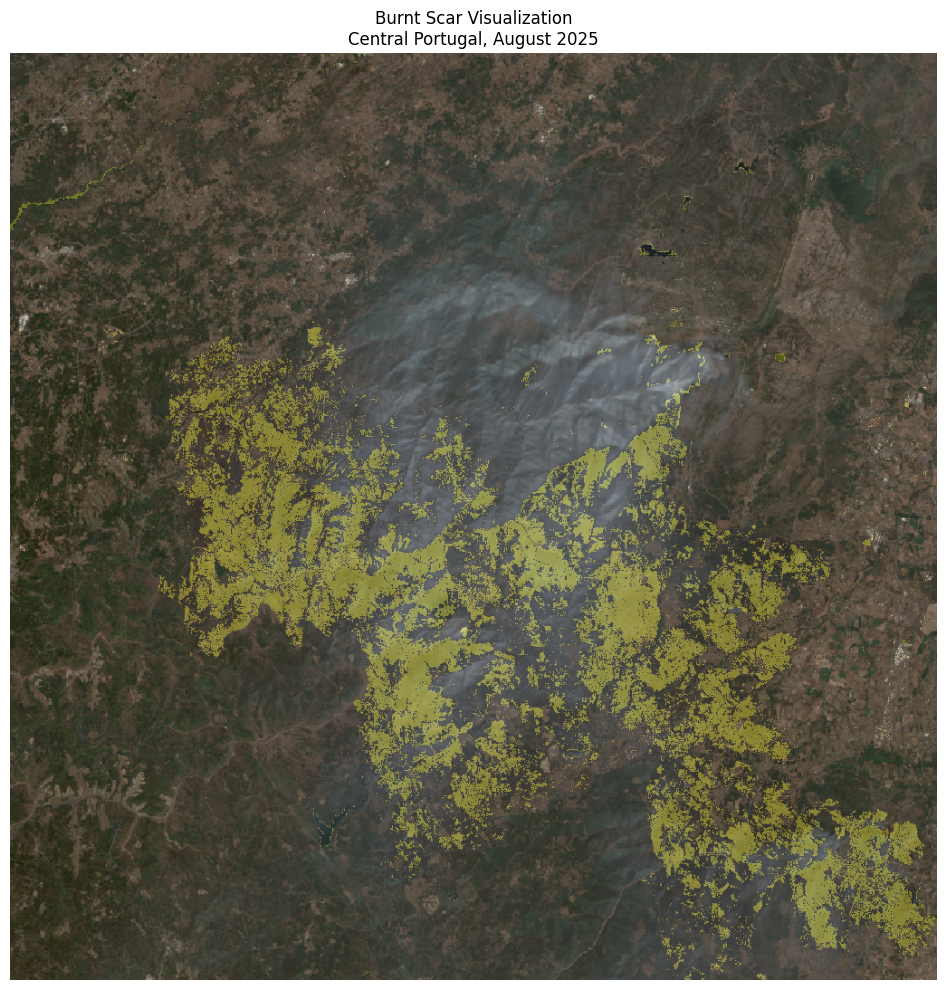

In [30]:
# Load and display the image
img = Image.open(file_name)

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
ax.imshow(img)
ax.set_title(plot_title, fontsize=12)
ax.axis("off")
plt.tight_layout()
plt.show()

### Citation:

If using this algorithm, please cite:

Markuse, P, 2022. Wildfire Visualization.

### References:

- Markuse, P. (2022, September 21). QuickFire 1.0 – Visualizing Fires in the Sentinel Hub EO Browser. Pierre Markuse. https://web.archive.org/web/20230709082534/https://pierre-markuse.net/2022/09/21/quickfire-1-0-visualizing-fires-in-the-sentinel-hub-eo-browser/

- Markuse, P. (2017). Visualizing (Wild)Fires in Sentinel-2 imagery through EO Browser. Pierre Markuse. https://web.archive.org/web/20230206114533/https://pierre-markuse.net/2017/08/07/visualizing-wildfires-sentinel-2-imagery-eo-browser/

- P. Markuse, QuickFire V1.0.0 – markuse_fire custom script, Sentinel Hub Custom Scripts, GitHub, Sep 2022. https://github.com/sentinel-hub/custom-scripts/blob/main/sentinel-2/markuse_fire/script.js

## Attribution

This openEO User-Defined Process is a conversion of the original Sentinel Hub evalscript:

**Original Script:** [Wildfire Visualization](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/markuse_fire/)

**Author:** Pierre Markuse

**Source Repository:** [Sentinel Hub Custom Scripts](https://github.com/sentinel-hub/custom-scripts)

This conversion maintains the scientific methodology and visualization approach of the original evalscript while adapting it to the openEO process graph framework for interoperability across openEO-compliant backends.